In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# Inspect the DB
inspector = inspect(engine)
tables = inspector.get_table_names()

for table in tables:
    print("\n")
    print(table)
    print('-'*10)
    columns = inspector.get_columns(table)
    
    for column in columns:
        print(column['name'],column['type'])



measurement
----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


station
----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

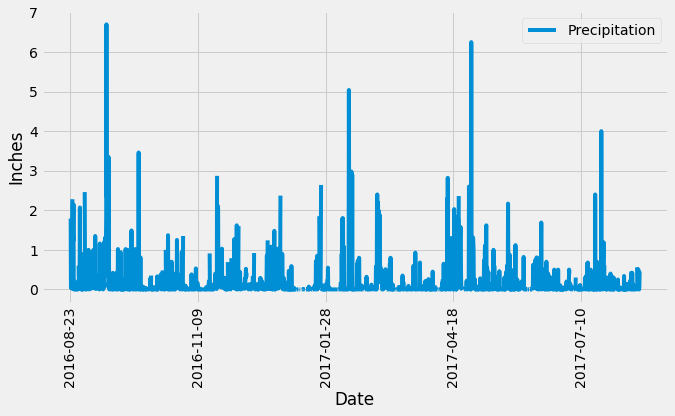

In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# get max date as a string from the Measurement table
smax_date = session.query(func.max(Measurement.date)).scalar()
# Convert smax_date into a date object
max_date = dt.datetime.strptime(smax_date,'%Y-%m-%d').date()
# Calculate the min date for retrieving last 12 months data
min_date = max_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

ppt_data = (session.query(Measurement.date,Measurement.prcp)
    .filter(Measurement.date >= min_date)
    .all()
)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(ppt_data,columns=['Date','Precipitation'])
#Set index to the date column
df.set_index('Date',inplace=True)
# Sort the dataframe by date
df.sort_values(by='Date',inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(10,5),rot=90)
plt.ylabel('Inches')
plt.legend(loc='upper right')

In [34]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [35]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station.station).group_by(Station.station).count()
total_stations

9

In [38]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = (session.query(Station.id,Station.station,func.count(Measurement.tobs))
    .filter(Station.station==Measurement.station)
    .group_by(Station.id,Station.station)
    .order_by(func.count(Measurement.tobs).desc())
    .all()
)
print(f'The station with the highest no. of observations is {most_active_stations[0][1]}')
most_active_stations

The station with the highest no. of observations is USC00519281


[(7, 'USC00519281', 2772),
 (1, 'USC00519397', 2724),
 (2, 'USC00513117', 2709),
 (6, 'USC00519523', 2669),
 (9, 'USC00516128', 2612),
 (3, 'USC00514830', 2202),
 (8, 'USC00511918', 1979),
 (4, 'USC00517948', 1372),
 (5, 'USC00518838', 511)]

In [39]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station_data = (session.query(Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))
    .filter(Station.id==7)
    .filter(Station.station==Measurement.station)
    .all()
)

print(f'The most active station {most_active_station_data[0][0]} has lowest temp. ' \
      f'{most_active_station_data[0][1]}, highest temp {most_active_station_data[0][2]} ' \
    f'and avg. temp {most_active_station_data[0][3]}')
most_active_station_data

The most active station USC00519281 has lowest temp. 54.0, highest temp 85.0 and avg. temp 71.66378066378067


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

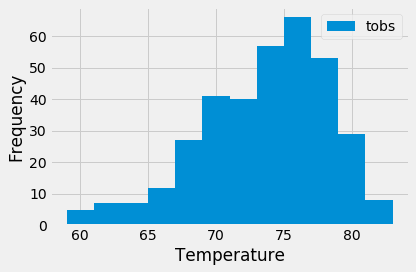

In [40]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = (session.query(Measurement.tobs)
    .filter(Measurement.date >= min_date)
    .filter(Measurement.station=='USC00519281')
    .all()
)

# Unpack the teperature tuples into a list for plotting
tobs_list = list(np.ravel(tobs_data))

# Create histogram
fig, ax = plt.subplots()
ax.hist(tobs_list,bins=12,label='tobs')
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')
ax.legend()
fig.tight_layout()

## Bonus Challenge Assignment

Temperature Analysis I

In [87]:
hawaii_df = pd.read_csv('Resources/hawaii_measurements.csv')
hawaii_df['date'] = pd.to_datetime(hawaii_df['date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19550 entries, 0 to 19549
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   station  19550 non-null  object        
 1   date     19550 non-null  datetime64[ns]
 2   prcp     18103 non-null  float64       
 3   tobs     19550 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 611.1+ KB


In [135]:
# Average temperature in June
mask1 = hawaii_df['date'].apply(lambda x : x.strftime('%m'))=='06'
june = hawaii_df.loc[mask1]['tobs']
avg_jun = june.mean()
# Average temperature in December
mask2 = hawaii_df['date'].apply(lambda x : x.strftime('%m'))=='12'
dec = hawaii_df.loc[mask2]['tobs']
avg_dec = dec.mean()

In [136]:
# Independent t-test will be used as the number of temperature observations are not equal for June and December 
from scipy import stats
stats.ttest_ind(june,dec)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

In [137]:
# Based on the p-value we can reject the NULL hypothesis (<0.05) and conclude that there is a statistical difference between
# the mean of temperatures of June and December

Temperature Analysis II

In [138]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [139]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
actual_s_start_date = '2020-08-01'
actual_s_end_date = '2020-08-07'
actual_d_start_date = dt.datetime.strptime(actual_s_start_date,'%Y-%m-%d').date()
actual_d_end_date = dt.datetime.strptime(actual_s_end_date,'%Y-%m-%d').date()

# Calculate start and end dates for calculations
calc_d_start_date = actual_d_start_date.replace(year=actual_d_start_date.year-3)
calc_d_end_date = actual_d_end_date.replace(year=actual_d_end_date.year-3)

calc_s_start_date = calc_d_start_date.strftime('%Y-%m-%d')
calc_s_end_date = calc_d_end_date.strftime('%Y-%m-%d')

temps = calc_temps(calc_s_start_date,calc_s_end_date)
temps_list = list(np.ravel(temps))

tmin = temps_list[0]
tavg = temps_list[1]
tmax = temps_list[2]

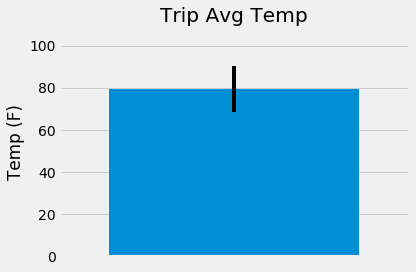

In [140]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
x=1
ax.bar(x,tavg,yerr=tmax-tmin,align='center')
ax.xaxis.set_visible(False)
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp (F)')
ax.margins(0.2,0.2)
fig.tight_layout()

In [141]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevatio
sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
prcp_per_station = (session.query(*sel)
    .filter(Station.station==Measurement.station)
    .filter(Measurement.date >= calc_s_start_date,Measurement.date<=calc_s_end_date)
    .group_by(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation)
    .order_by(func.sum(Measurement.prcp).desc())
    .all()
)
prcp_per_station

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.36),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.22),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.06),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0)]

In [142]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [143]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates
trip_dates = [(actual_d_start_date + dt.timedelta(n)) for n in range((actual_d_end_date-actual_d_start_date).days + 1) ]
calc_dates = [(calc_d_start_date + dt.timedelta(n)) for n in range((calc_d_end_date-calc_d_start_date).days + 1) ]

# Stip off the year and save a list of %m-%d strings
calc_str_dates = [ ddates.strftime('%m-%d') for ddates in calc_dates]

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normal_list = []
for date in calc_str_dates:
    normals = daily_normals(date)
    daily_normal_list.append(normals[0])

In [144]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(daily_normal_list,index=trip_dates,columns=['TMIN','TAVG','TMAX'])
df

,TMIN,TAVG,TMAX
2020-08-01,67.0,75.540000,83.0
2020-08-02,68.0,75.603774,84.0
2020-08-03,70.0,76.611111,85.0
2020-08-04,69.0,76.711538,84.0
2020-08-05,69.0,76.148148,82.0
2020-08-06,67.0,76.250000,83.0
2020-08-07,71.0,77.156863,83.0


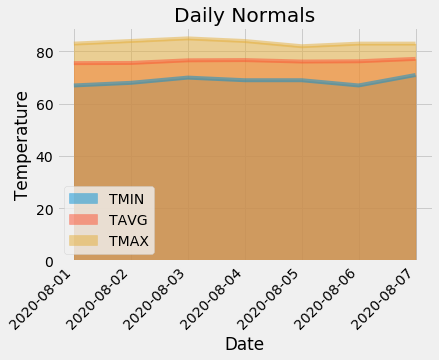

In [145]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.xticks(rotation=45,ha='right')
plt.title('Daily Normals')
plt.legend(loc='best')